# Udacity Machine Learning Capstone Project
## Dogs vs. Cats Redux - Kaggle Compeition

## Load modules

In [1]:
import hashlib
import os
import pickle
import time
import random
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
print('All modules imported.')

All modules imported.


## Load Data

In [2]:
SIZE = 32

# Reload the data
pickle_file = 'DogCat_{0}px_2500.pickle'.format(SIZE)
with open(pickle_file, 'rb') as f:
  pickle_data = pickle.load(f)
  X_train = pickle_data['train_dataset']
  y_train = pickle_data['train_labels']
  X_val = pickle_data['valid_dataset']
  y_val = pickle_data['valid_labels']
  del pickle_data  # Free up memory
    
print('Data and modules loaded.')

Data and modules loaded.


Updated Image Shape: (32, 32, 3)
0


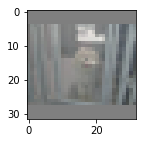

In [10]:
print('Updated Image Shape: {}'.format(X_train[0].shape))
index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(2,2))
plt.imshow(image)
print(y_train[index])

In [3]:
print(X_train.shape)
print(X_val.shape)

(2000, 32, 32, 3)
(500, 32, 32, 3)


## Implement LeNet-5 as Baseline in TensorFlow

### Input
The LeNet architecture accepts a 32x32xC image as input, where C is the number of color channels. C is 3 in this case.

### Architecture
**Layer 1: Convolutional.** The output shape should be 28x28x6.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 14x14x6.

**Layer 2: Convolutional.** The output shape should be 10x10x16.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 5x5x16.

**Flatten.** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D. 

**Layer 3: Fully Connected.** This should have 120 outputs.

**Activation.** Relu

**Layer 4: Fully Connected.** This should have 84 outputs.

**Activation.** Relu

**Layer 5: Fully Connected (Logits).** This should have 2 outputs.

### Output
Return the result of the 2nd fully connected layer.

In [11]:
def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0.0
    sigma = 0.1
    weights = {
        'wc1': tf.Variable(tf.truncated_normal((5, 5, 3, 6), mean = mu, stddev = sigma)),
        'wc2': tf.Variable(tf.truncated_normal((5, 5, 6, 16), mean = mu, stddev = sigma)),
        'wf1': tf.Variable(tf.truncated_normal((400, 120), mean = mu, stddev = sigma)),
        'wf2': tf.Variable(tf.truncated_normal((120, 84), mean = mu, stddev = sigma)),
        'wf3': tf.Variable(tf.truncated_normal((84, 2), mean = mu, stddev = sigma))
    }
    
    biases = {
        'bc1': tf.Variable(tf.zeros(6)),
        'bc2': tf.Variable(tf.zeros(16)),
        'bf1': tf.Variable(tf.zeros(120)),
        'bf2': tf.Variable(tf.zeros(84)),
        'bf3': tf.Variable(tf.zeros(2))
    }
    # TODO: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv_layer1 = tf.nn.conv2d(x, weights['wc1'], strides = [1, 1, 1, 1], padding = 'VALID')
    conv_layer1 = tf.nn.bias_add(conv_layer1, biases['bc1'])
    # TODO: Activation.
    conv_layer1 = tf.nn.relu(conv_layer1)
    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv_layer1 = tf.nn.max_pool(conv_layer1, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'VALID')
    
    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    conv_layer2 = tf.nn.conv2d(conv_layer1, weights['wc2'], strides = [1, 1, 1, 1], padding = 'VALID')
    conv_layer2 = tf.nn.bias_add(conv_layer2, biases['bc2'])
    
    # TODO: Activation.
    conv_layer2 = tf.nn.relu(conv_layer2)
    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv_layer2 = tf.nn.max_pool(conv_layer2, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'VALID')

    # TODO: Flatten. Input = 5x5x16. Output = 400.
    fc0 = flatten(conv_layer2)
    
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1 = tf.add(tf.matmul(fc0, weights['wf1']), biases['bf1'])
    # TODO: Activation.
    fc1 = tf.nn.relu(fc1)
    
    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2 = tf.add(tf.matmul(fc1, weights['wf2']), biases['bf2'])

    # TODO: Activation.
    fc2 = tf.nn.relu(fc2)

    # TODO: Layer 5: Fully Connected. Input = 84. Output = 2.
    fc3 = tf.add(tf.matmul(fc2, weights['wf3']), biases['bf3'])
    logits = fc3
    return logits

## Features and Labels

In [12]:
x = tf.placeholder(tf.float32, (None, SIZE, SIZE, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 2)

## Training Pipeline

In [19]:
EPOCHS = 100
BATCH_SIZE = 128
rate = 0.0003

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

## Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.

You do not need to modify this section.

In [20]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## Train the Model
Run the training data through the training pipeline to train the model.

Before each epoch, shuffle the training set.

After each epoch, measure the loss and accuracy of the validation set.

Save the model after training.

You do not need to modify this section.

In [21]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    valid_acc = []
    print("Training...")
    print()
    for i in range(EPOCHS):
        t0 = time.time()
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_val, y_val)
        print("EPOCH {} ...".format(i+1))
        print("Time: %.3f seconds" % (time.time() - t0))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        valid_acc.append(validation_accuracy)
        
    saver.save(sess, './DogsCats_lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Time: 1.759 seconds
Validation Accuracy = 0.472

EPOCH 2 ...
Time: 1.758 seconds
Validation Accuracy = 0.534

EPOCH 3 ...
Time: 1.786 seconds
Validation Accuracy = 0.534

EPOCH 4 ...
Time: 1.797 seconds
Validation Accuracy = 0.506

EPOCH 5 ...
Time: 1.919 seconds
Validation Accuracy = 0.588

EPOCH 6 ...
Time: 2.157 seconds
Validation Accuracy = 0.594

EPOCH 7 ...
Time: 1.754 seconds
Validation Accuracy = 0.608

EPOCH 8 ...
Time: 1.936 seconds
Validation Accuracy = 0.590

EPOCH 9 ...
Time: 2.275 seconds
Validation Accuracy = 0.626

EPOCH 10 ...
Time: 2.241 seconds
Validation Accuracy = 0.640

EPOCH 11 ...
Time: 1.971 seconds
Validation Accuracy = 0.624

EPOCH 12 ...
Time: 1.835 seconds
Validation Accuracy = 0.626

EPOCH 13 ...
Time: 1.753 seconds
Validation Accuracy = 0.620

EPOCH 14 ...
Time: 1.879 seconds
Validation Accuracy = 0.610

EPOCH 15 ...
Time: 1.801 seconds
Validation Accuracy = 0.634

EPOCH 16 ...
Time: 1.803 seconds
Validation Accuracy = 0.664

EPOC

100


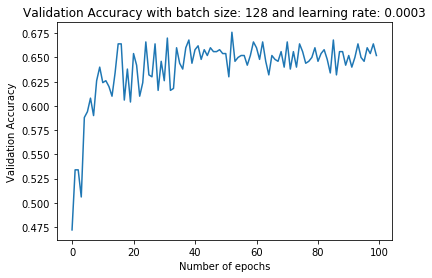

In [22]:
print(len(valid_acc))
plt.title('Validation Accuracy with batch size: {0} and learning rate: {1}'.format(BATCH_SIZE, rate))
plt.xlabel('Number of epochs')
plt.ylabel('Validation Accuracy')
#plt.xlim([0, EPOCHS])
#plt.ylim([0.5, 1])
plt.plot(valid_acc)